In [1]:
import matplotlib.pyplot as plt
import numpy as np
from utils import *

In [ ]:
! wget https://s3.amazonaws.com/drivendata-prod/data/44/public/dengue_features_train.csv -P ./data/sub
! wget https://s3.amazonaws.com/drivendata-prod/data/44/public/dengue_labels_train.csv -P ./data/sub
! wget https://s3.amazonaws.com/drivendata-prod/data/44/public/dengue_features_test.csv -P ./data/sub

In [2]:
train_df, test_df = load_data()

shape train feature: (1456, 24)
shape train labels: (1456, 4)
shape test feature: (416, 24)
shape train merge: (1456, 25)


## Checking how KNN and IterativeImputer performs for imputing missing data

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

d_cols = ['city', 'year', 'weekofyear', 'week_start_date']
train_to_impute = train_df.drop(columns=d_cols)
iimputer = IterativeImputer(max_iter=100, random_state=0)
knnimputer = KNNImputer(add_indicator=True)
train_imp = iimputer.fit_transform(train_to_impute)
train_imp_knn = knnimputer.fit_transform(train_to_impute)
missings = train_imp_knn[:, 21:].astype(bool)
train_imp_knn = train_imp_knn[:,:21]

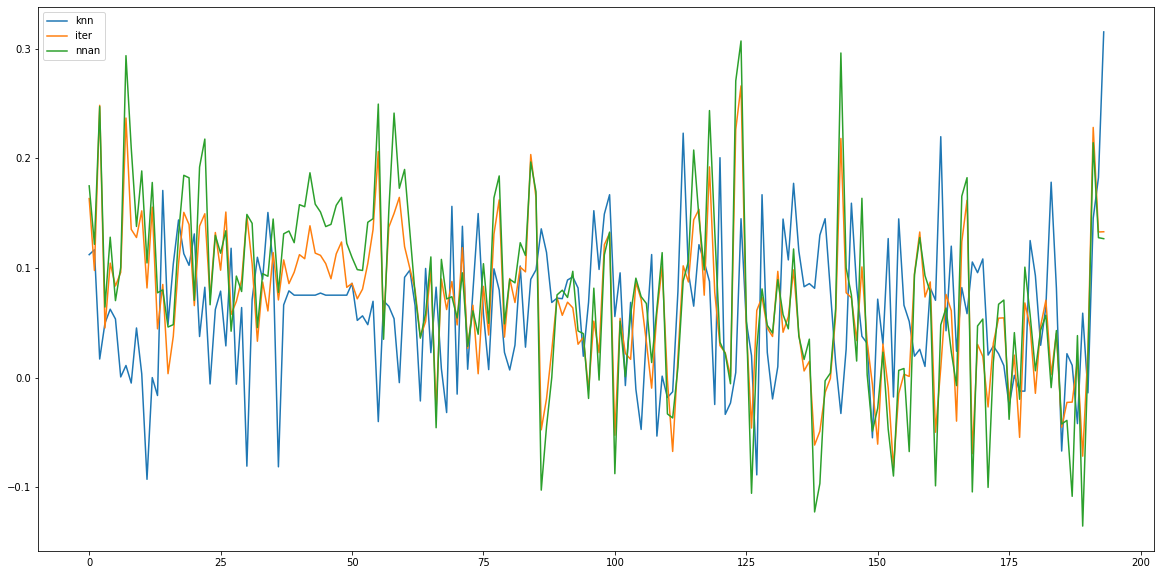

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(train_imp_knn[missings[:,0], 0], label='knn')
ax.plot(train_imp[missings[:,0], 0], label='iter')
ax.plot(train_imp[missings[:,0], 1], label='nnan')

plt.legend()


IterativeImputer seems more in line with other features    

## Format the data specifically for AWS SageMaker DeepAR model

In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

def impute_nan(train_data, imputer=None):  
    if imputer==None:
        imputer = IterativeImputer(max_iter=100, random_state=0)
    train_imp = imputer.fit_transform(train_data)
    features = train_imp
    return features, imputer

def create_json_obj(city, start_date, labels, features):
    dic_ts = {
        'start': str(start_date),
        'target': labels,
        'cat': [CITIES_DICT[city]],
        'dynamic_feat': features.T.tolist()
    }
    
    json_ts = json.dumps(dic_ts)
    return json_ts

feature_cols = [0, 1, 2, 3] # keeping only the NDVI
d_cols = ['city', 'year', 'weekofyear', 'week_start_date', 'total_cases']
train_data_json = []
test_data_json = []
for city in CITIES_DICT:
    print(city)
    # training data
    city_data = train_df[train_df.city==city]
    start_date = city_data.week_start_date.iloc[0]
    features = city_data.drop(columns=d_cols)
    labels = city_data[ 'total_cases'].tolist()
    features_imp, imputer = impute_nan(features)    
    train_data_json.append( create_json_obj(city, 
                                      start_date, 
                                      labels, 
                                      features_imp[:, feature_cols]) )
    # testing data
    city_data_test = test_df[test_df.city==city]
    test_features = city_data_test.drop(columns=d_cols, errors='ignore') # so we don't get an error on `total_cases`
    test_features_imp, _ = impute_nan(test_features, imputer)
    test_features_imp_w_context = np.append(features_imp, test_features_imp, axis=0)
    test_data_json.append( create_json_obj(city, 
                                      start_date, 
                                      labels, 
                                      test_features_imp_w_context[:, feature_cols]) )


iq
sj


In [8]:
write_json(train_data_json, TRAIN_JSON)
write_json(test_data_json[CITIES_DICT['sj']], TEST_JSON_SJ)
write_json(test_data_json[CITIES_DICT['iq']], TEST_JSON_IQ)

Wrote 28536 chars to ./data/train.json
Wrote 50218 chars to ./data/train.json
./data/train.json saved
Wrote 36544 chars to ./data/test.json
Wrote 63288 chars to ./data/test.json
./data/test.json saved
